In [1]:
import numpy as np
from scipy.fftpack import dct, idct
from PIL import Image
import matplotlib.pyplot as plt


In [5]:
from google.colab import files
uploaded = files.upload()

Saving img.jpg to img (1).jpg


In [6]:
image_path = list(uploaded.keys())[0]
image = Image.open(image_path).convert('L')
image = image.resize((256, 256))
image_array = np.array(image, dtype=np.float32)

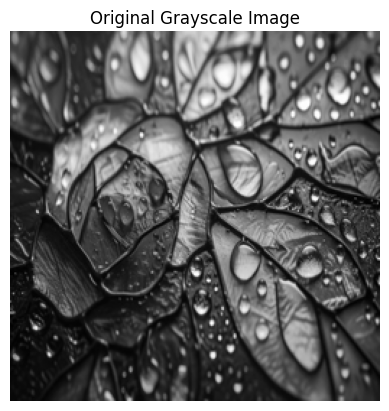

In [7]:
plt.imshow(image_array, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')
plt.show()

In [8]:
def split_into_blocks(image, block_size=8):
    height, width = image.shape
    blocks = []
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image[i:i+block_size, j:j+block_size]
            blocks.append(block)
    return blocks
blocks = split_into_blocks(image_array)

In [9]:
def apply_dct(block):
    dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
    return dct_block

dct_blocks = [apply_dct(block) for block in blocks]

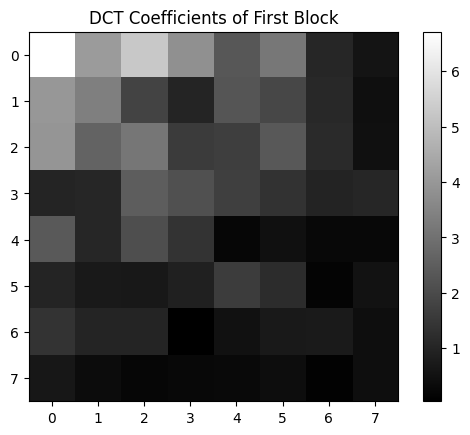

In [10]:
plt.imshow(np.log1p(np.abs(dct_blocks[0])), cmap='gray')
plt.title("DCT Coefficients of First Block")
plt.colorbar()
plt.show()

In [11]:
quantization_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

In [12]:
def quantize_block(dct_block, quantization_matrix):
    return np.round(dct_block / quantization_matrix)
quantized_blocks = [quantize_block(block, quantization_matrix) for block in dct_blocks]

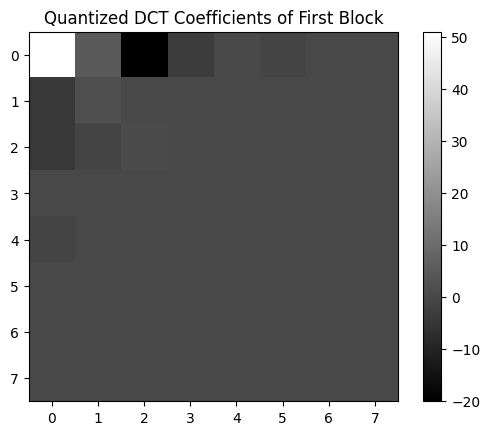

In [13]:
plt.imshow(quantized_blocks[0], cmap='gray')
plt.title("Quantized DCT Coefficients of First Block")
plt.colorbar()
plt.show()

In [14]:
def dequantize_block(quantized_block, quantization_matrix):
    return quantized_block * quantization_matrix

dequantized_blocks = [dequantize_block(block, quantization_matrix) for block in quantized_blocks]

In [15]:
def apply_idct(dct_block):
    return idct(idct(dct_block.T, norm='ortho').T, norm='ortho')

reconstructed_blocks = [apply_idct(block) for block in dequantized_blocks]

In [16]:
def combine_blocks(blocks, image_shape):
    height, width = image_shape
    block_size = blocks[0].shape[0]
    image = np.zeros((height, width))
    index = 0
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            image[i:i+block_size, j:j+block_size] = blocks[index]
            index += 1
    return image

reconstructed_image = combine_blocks(reconstructed_blocks, image_array.shape)

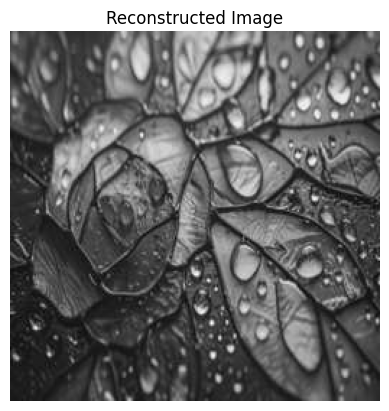

In [17]:
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()

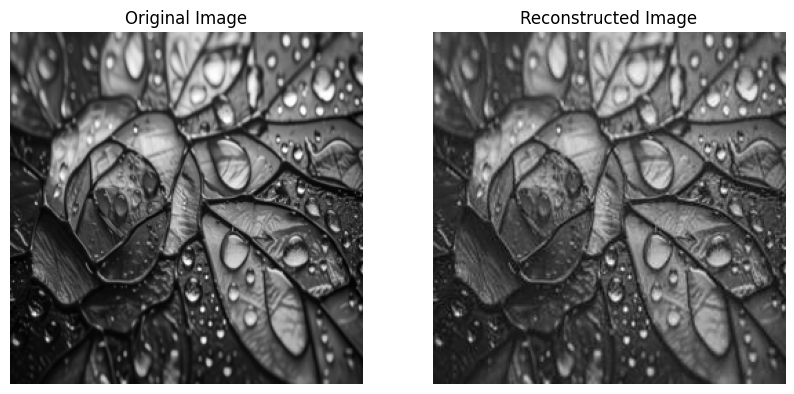

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_array, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')
plt.show()

In [19]:
mse = np.mean((image_array - reconstructed_image) ** 2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 44.52571583222689


DCT: Converts spatial data into frequency components.

Quantization: Reduces precision of high-frequency coefficients (most become zero).

Reconstruction: Inverse DCT brings back the spatial data, but with some loss.
